<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing-Data" data-toc-modified-id="Preprocessing-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing Data</a></span><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Inspect-the-DataFrame" data-toc-modified-id="Inspect-the-DataFrame-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Inspect the DataFrame</a></span></li><li><span><a href="#Winsorization" data-toc-modified-id="Winsorization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Winsorization</a></span></li><li><span><a href="#Standardization" data-toc-modified-id="Standardization-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Standardization</a></span></li><li><span><a href="#Neutralization" data-toc-modified-id="Neutralization-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Neutralization</a></span></li></ul></li><li><span><a href="#Scoring-the-stocks" data-toc-modified-id="Scoring-the-stocks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scoring the stocks</a></span><ul class="toc-item"><li><span><a href="#Calculate-daily-return" data-toc-modified-id="Calculate-daily-return-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate daily return</a></span></li><li><span><a href="#Calculate-factor-weights-in-order-to-calculate-the-final-score" data-toc-modified-id="Calculate-factor-weights-in-order-to-calculate-the-final-score-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Calculate factor weights in order to calculate the final score</a></span></li><li><span><a href="#Scores" data-toc-modified-id="Scores-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Scores</a></span><ul class="toc-item"><li><span><a href="#Calculate-factor-weights-in-order-to-calculate-final-score" data-toc-modified-id="Calculate-factor-weights-in-order-to-calculate-final-score-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Calculate factor weights in order to calculate final score</a></span></li><li><span><a href="#Calculate-scores" data-toc-modified-id="Calculate-scores-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Calculate scores</a></span></li></ul></li><li><span><a href="#Check-the-results" data-toc-modified-id="Check-the-results-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check the results</a></span><ul class="toc-item"><li><span><a href="#The-correlation-between-score-and-returns" data-toc-modified-id="The-correlation-between-score-and-returns-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>The correlation between score and returns</a></span></li><li><span><a href="#Accumulate-returns-by-score-groups" data-toc-modified-id="Accumulate-returns-by-score-groups-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Accumulate returns by score groups</a></span></li></ul></li></ul></li></ul></div>

## Preprocessing Data

### Preparation

In [1316]:
# Let's define the factors we're going to use
feature_names = ['SUR0', 'vol60', 'book_to_price', 'vol20']

additional_data =['sector', 'marketCap', 'adjClose']

# In order not to distort the original data, let's copy the original data
result_df = pd.read_csv('/Users/michael/Desktop/result.csv', index_col=[0,1])
_df = result_df[feature_names + additional_data].copy(deep=True)

### Inspect the DataFrame
Missing data will lead to corrupted data. So before we start processing data, we need to inspect the data and see whether there are any empty data. `missingno` will be a good tool to detect the missing data including empty string, Nan, ...etc.

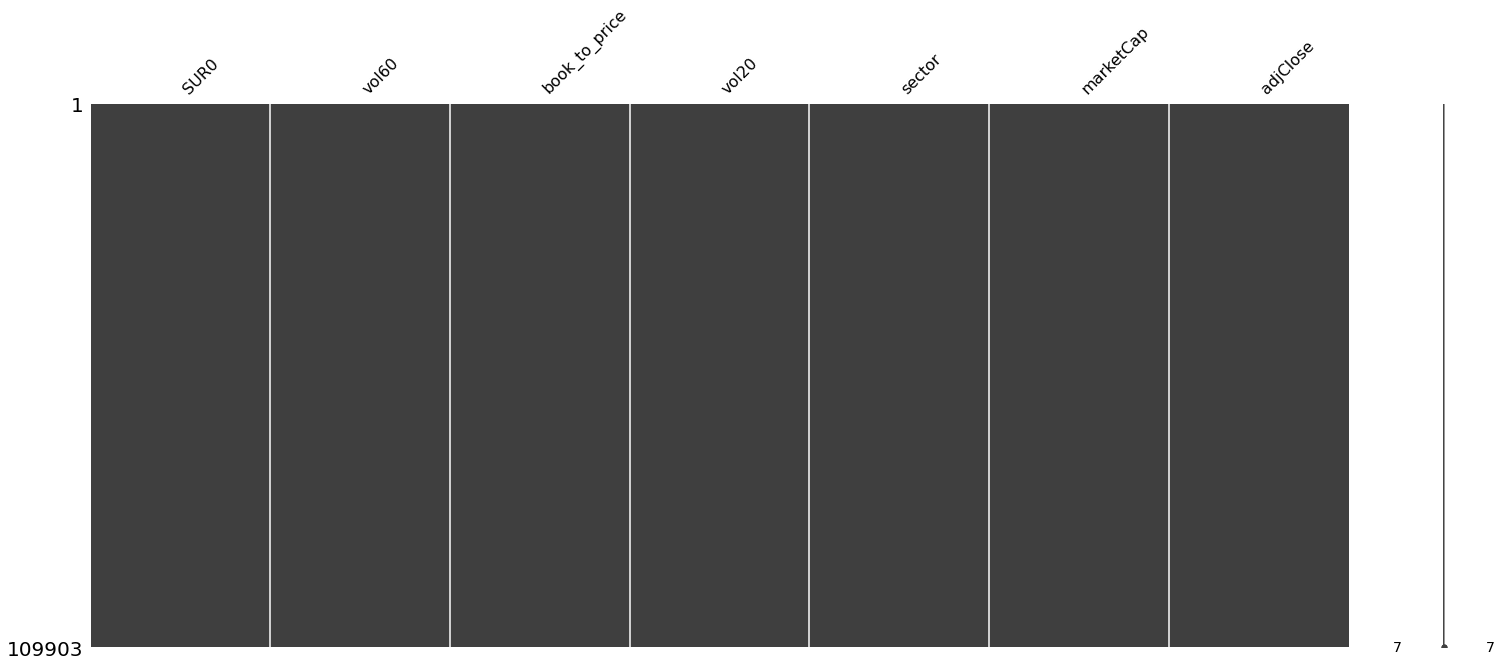

In [1317]:
import missingno as msno
msno.matrix(_df)

We have `109903` rows of data without missing data. Good. Let's proceed with the data standardization.

Three steps:
1. **Winsorization**
2. **Industry neutralization**
3. **Standardization**

### Winsorization
**MAD (Median Absolute Deviation)**

MAD is to evaluate the level of deviation of each sample from the true mean of the entire set. We will use MAD as the base unit to winsorize our data set.

$$MAD = median(\left\vert x_i - median(x)\right\vert)$$

**3σ winsorization**

3σ winsorization means we will keep the values that are in the range $[x - 3*\sigma*MAD, x-3*\sigma*MAD]$ where `$\simga$ stands for standard deviation`. For the extreme values that exceed this range, we will replace them with the edge value. By doing so, we will be able to eliminate the impact that comes from the extreme value.

> Reference: [3σ winsorization using median absolute deviation](http://www.dongdaima.com/article/76738)

In [1318]:
median = _df[feature_names].median(axis=0)
MAD = abs(_df[feature_names].sub(median, axis=1)).median(axis=0)
MAD_THRESHOLD = 3
sigma = _df[feature_names].std(axis=0)

# Use clip() to define the upperbound and lowerbound. 
# Any number exceeded that boundaries will be replaced by the upper and lower bound themselves
_df.loc[:, feature_names] = _df.loc[:, feature_names].clip(
    lower=(median - MAD_THRESHOLD * sigma * MAD), 
    upper=(median + MAD_THRESHOLD * sigma * MAD), 
    axis=1
)

### Standardization
The most common way to standardize a series of numbers, is so called `Z-Score`, 
$$x_{i}^{'} = \frac{x_i - mean(x)}{std(x)}$$

In [1319]:
_df.loc[:, feature_names] = (
    (
        _df.loc[:, feature_names] - 
        _df.loc[:, feature_names].mean()
    ) / _df.loc[:, feature_names].std()
)

### Neutralization
We use OLS linear regression to find the residual of each factor. The residual $\epsilon$ in linear regression could be interpreted as the part that can not be explained by any of the independent variables, further neutralize the impact of the independent variables by removing them.

$$y_i = sector * x1_i + marketCap * x2_i + \epsilon$$

In this formula, we're going to neutralize the impact of the industry sector and market cap as these are commonly the biggest impacts.

In [1320]:
# Get OLS linear regression residual
def calc_resid(x: pd.DataFrame, y: pd.Series) -> float:
    result = sm.OLS(y, x).fit()
    return result.resid

In [1321]:
X = pd.get_dummies(_df['sector'])
X['marketCap'] = np.log(_df['marketCap'])

neutralized_df = pd.concat([calc_resid(X.fillna(0), _df[i]) for i in feature_names], axis=1)
neutralized_df.columns = feature_names

neutralized_df['sector'] = _df['sector']
neutralized_df['marketCap'] = _df['marketCap']
neutralized_df['adjClose'] = _df['adjClose']

## Scoring the stocks
### Calculate daily return
Finally get to the scoring part. 

First of all, let's use [`logarithmic return`](https://www.investopedia.com/ask/answers/05/logvslinear.asp) instead of arithmetic average return for calculating the daily return. 

There is an issue when using arithmetic average to calculate our return over time. Let's say, stock `abc` stock price rise 10% from $10 to $11, and rise another 15% in the second day. The total return for two days doesn't equal to $10\% + 15\% = 25\%$. Instead, it's $10\% + (1+10\%)*15\% = 26.5\%$.

However, the advantage of using logarithmic return is that you simply need to add log return of these two days to get the total return. This benefit is really useful in this tutorial. Even though log return rising 10% doesn't necessarily mean you earn 10% cash, it still adds value by making it easy to see the difference between two groups over time.

In [1322]:
prepared_df = neutralized_df.copy(deep=True)

rtn = prepared_df.reset_index()
rtn = pd.pivot(rtn[['date', 'ticker', 'adjClose']], index='date', columns='ticker', values='adjClose')
rtn = rtn.pct_change()
rtn = rtn.iloc[:-1]
rtn = rtn.stack()
prepared_df['rtn'] = rtn
prepared_df['log_rtn'] = np.log(1 + rtn)

prepared_df.to_csv('/Users/michael/Desktop/prepared_data.csv')

In [1323]:
prepared_df = pd.read_csv('/Users/michael/Desktop/prepared_data.csv').sort_values(['date', 'ticker'])
prepared_df['date'] = pd.to_datetime(prepared_df['date'])
prepared_df.set_index(['date', 'ticker'], inplace=True)

### Calculate factor weights in order to calculate the final score
To make sure we have enough data to get IC correctly, we need to waive those days that have very few rows of data. So let's drop those days that have less than 200 rows of data.

In [1324]:
# Required number of sample data per day
N = 200
prepared_df = prepared_df.dropna().groupby(level='date').filter(lambda x: len(x) > N)

Once we have more than 200 rows of data per day, then we can proceed to calculate the IC and IR.

In [1325]:
IC = prepared_df.groupby(level='date').apply(
    lambda x: [stats.spearmanr(x[factor], x['rtn'], nan_policy='omit')[0] for factor in feature_names]
)

IC = pd.DataFrame(IC.tolist(), index=IC.index, columns=feature_names)
IC_abs = IC.abs()

# Get rolling mean for 12 period
rolling_ic = IC_abs.rolling(12, min_periods=1).mean()
rolling_ic_std = IC_abs.rolling(12, min_periods=1).std()

IR = rolling_ic / rolling_ic_std
IR.iloc[0,:] = rolling_ic.iloc[0,:]

### Scores

#### Calculate factor weights in order to calculate final score


In [1326]:
# Calculate the weight of each IR
IR_weights = IR.div(IR.sum(axis=1), axis=0)

#### Calculate scores

$$Factor\ score = \sum_{n=1}^{number\ of\ factors} factor_n * {IR\ weight}_n$$

We multiply the factor itself with its IR weight, then we sum them up to get the final factor score.

In [1327]:
# Get factor score
prepared_df['SCORE'] = (prepared_df[feature_names].mul(IR_weights)).sum(axis=1)

### Check the results

#### The correlation between score and returns
We can do a quick check for the correlation between `log return` and `score`. If we have a higher number here, meaning we might have a good result as higher score has higher log return.

In [1328]:
prepared_df[['log_rtn', 'SCORE']].corr('spearman').iloc[1,0]

0.03047315737946123

#### Accumulate returns by score groups
Lastly, we can do a quick line plot to see the return distribution across different groups.

1. Sort the stocks by factor score
2. Split the stocks into 8 groups that contain an equal number of stocks.
3. Add up the daily return in the same group and compare it to the other groups over time.

What we're looking for here is to find a nice combination of factors that can help pick the good stocks.

In [1329]:
_prepared_df = snp_scaffolding.copy()
_prepared_df['sector'] = prepared_df['sector']
_prepared_df['SCORE'] = prepared_df['SCORE']
_prepared_df['log_rtn'] = prepared_df['log_rtn']
_prepared_df.dropna(inplace=True)
_prepared_df.index = _prepared_df.index.droplevel(1)
_prepared_df.reset_index().drop(columns='date', inplace=True)

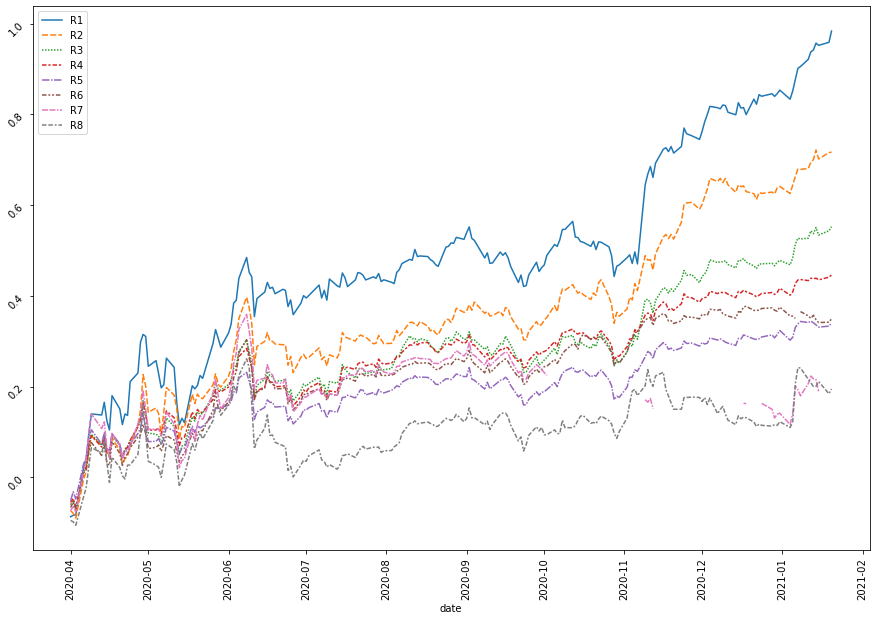

In [1330]:
_prepared_df['rate'] = _prepared_df.groupby('date')['SCORE'].apply(lambda x : pd.cut(x, bins=8, labels=['R8', 'R7', 'R6','R5','R4','R3','R2','R1']))
x = _prepared_df.groupby(['date', 'rate'])['log_rtn'].apply(lambda x: x.sum()/len(x)).reset_index().set_index(['rate', 'date'])
z = pd.DataFrame(index=x.loc['R1'].index)
    
for i in range(1,9):
    z[f'R{i}'] = x.loc[f'R{i}',:].cumsum()
    
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)

Ummm, seems we have a good start here. 

The return with the highest score in `R1` group tends to go higher, and the lowest score in `R8` group has the lowest return.

Remember, we can experiment with this procedure several times to make sure we have a nice factor analysis model here.